In [1]:
import sys
import os
sys.path.append(os.path.abspath("../.."))

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random

from models.lstm import LSTMRegressor
from models.mlp_encoder import MLPEncoder
from utils.stock_data import get_log_return_loaders, StockIndex
from utils.early_stopping import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


In [2]:
window_size=7

BEST_LSTM_PARAMS = {
    StockIndex.NVDA: {
        "hidden_dim": 352,
        "num_layers": 3,
        "dropout": 0.35533961672900083,
        "batch_size": 16,
        "lr": 0.00011110887344303596
    },
    StockIndex.AAPL: {
        "hidden_dim": 224,
        "num_layers": 3,
        "dropout": 0.4352854918415097,
        "batch_size": 64,
        "lr": 0.0012493070903409715
    },
    StockIndex.KO: {
        "hidden_dim": 32,
        "num_layers": 3,
        "dropout": 0.3159847161164443,
        "batch_size": 64,
        "lr": 0.0034995329242571388
    }
}

BEST_MLP_PARAMS = {
    StockIndex.NVDA: {
        "layer_0_dim": 32,
        "dropout": 0.2897991884982838,
        "lr": 0.0009668228045708458
    },
    StockIndex.AAPL: {
        "layer_0_dim": 64,
        "dropout": 0.49874603484197316,
        "lr": 0.0006285029108482047
    },
    StockIndex.KO: {
        "layer_0_dim": 224,
        "layer_1_dim": 224,
        "dropout": 0.4541575041346178,
        "lr": 0.0009548721079891713
    }
}

## Training MLP-Fixed LSTM for each stock ##

### NVIDIA ###

In [3]:
stock = StockIndex.NVDA
lstm_params = BEST_LSTM_PARAMS[stock]
mlp_params = BEST_MLP_PARAMS[stock]
train_dl, val_dl, test_dl = get_log_return_loaders(
    stock,
    window_size=7,
    batch_size=lstm_params["batch_size"]
)
input_dim = next(iter(train_dl))[0].shape[-1]

Epoch 1: Train Loss = 0.001149 | Val Loss = 0.000712
Epoch 2: Train Loss = 0.001103 | Val Loss = 0.000685
Epoch 3: Train Loss = 0.001103 | Val Loss = 0.000718
Epoch 4: Train Loss = 0.001109 | Val Loss = 0.000685
Epoch 5: Train Loss = 0.001119 | Val Loss = 0.000719
Epoch 6: Train Loss = 0.001119 | Val Loss = 0.000689
Epoch 7: Train Loss = 0.001094 | Val Loss = 0.000692
Epoch 8: Train Loss = 0.001105 | Val Loss = 0.000686
Epoch 9: Train Loss = 0.001096 | Val Loss = 0.000713
Epoch 10: Train Loss = 0.001087 | Val Loss = 0.000685
Epoch 11: Train Loss = 0.001086 | Val Loss = 0.000691
Epoch 12: Train Loss = 0.001096 | Val Loss = 0.000721
Epoch 13: Train Loss = 0.001084 | Val Loss = 0.000687
Epoch 14: Train Loss = 0.001089 | Val Loss = 0.000690
Epoch 15: Train Loss = 0.001094 | Val Loss = 0.000688
Epoch 16: Train Loss = 0.001090 | Val Loss = 0.000697
Epoch 17: Train Loss = 0.001092 | Val Loss = 0.000689
Epoch 18: Train Loss = 0.001085 | Val Loss = 0.000690
Epoch 19: Train Loss = 0.001083 | Val

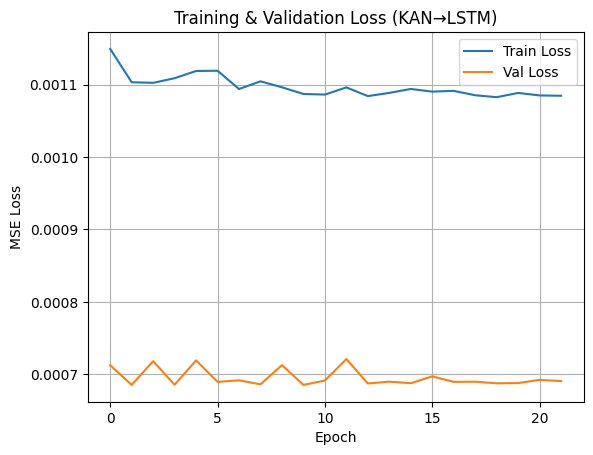

In [4]:
nvda_encoder = MLPEncoder(input_dim=input_dim,
                         layer_dims=[mlp_params['layer_0_dim']],
                         dropout=mlp_params['dropout']
                        ).to(device)

nvda_lstm = LSTMRegressor(
    input_dim=mlp_params['layer_0_dim'],
    hidden_dim=lstm_params['hidden_dim'],
    num_layers=lstm_params['num_layers'],
    dropout=lstm_params['dropout']
).to(device)

optimizer = optim.Adam([
    {'params': nvda_encoder.parameters(), 'lr': mlp_params['lr']},
    {'params': nvda_lstm.parameters(), 'lr': lstm_params['lr']}
])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
criterion = nn.MSELoss()
early_stopper = EarlyStopping(patience=20, min_delta=1e-5)

train_losses = []
val_losses = []

for epoch in range(50):
    # ---- TRAIN ----
    nvda_encoder.train()
    nvda_lstm.train()
    train_loss = 0.0
    for xb, yb, _ in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        encoded = nvda_encoder(xb)
        preds = nvda_lstm(encoded).squeeze()
        mse_loss = criterion(preds, yb)

        mse_loss.backward()
        optimizer.step()
        train_loss += mse_loss.item()

    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    # ---- VALIDATE ----
    nvda_encoder.eval()
    nvda_lstm.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb, _ in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            encoded = nvda_encoder(xb)
            preds = nvda_lstm(encoded).squeeze()
            val_loss += criterion(preds, yb).item()
    val_loss /= len(val_dl)
    val_losses.append(val_loss)

    scheduler.step(val_loss)
    early_stopper(val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.6f} | Val Loss = {val_loss:.6f}")

    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# ---- Plot ----
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Training & Validation Loss (KAN→LSTM)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()

Mean predicted return: 0.0014559599
Std of predicted return: 0.00056843547
Mean actual return: 0.002643923
Std of actual return: 0.032575168
Test RMSE: 3.8650
Test MAE : 3.0081


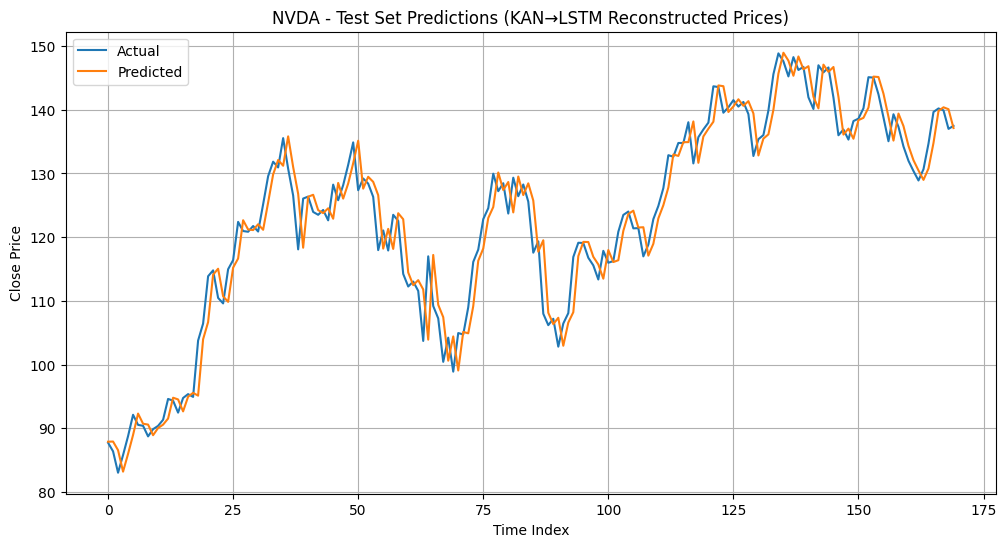

In [5]:
nvda_encoder.eval()
nvda_lstm.eval()

preds, targets, prev_prices = [], [], []

with torch.no_grad():
    for xb, yb, p_tm1 in test_dl:
        xb = xb.to(device)
        encoded = nvda_encoder(xb)
        y_pred = nvda_lstm(encoded).squeeze().cpu().numpy()

        preds.extend(y_pred)
        targets.extend(yb.numpy())
        prev_prices.extend(p_tm1.numpy())

# Convert to arrays
preds = np.array(preds)
targets = np.array(targets)
prev_prices = np.array(prev_prices)

# Reconstruct prices
pred_prices = prev_prices * np.exp(preds)
true_prices = prev_prices * np.exp(targets)

print("Mean predicted return:", np.mean(preds))
print("Std of predicted return:", np.std(preds))

print("Mean actual return:", np.mean(targets))
print("Std of actual return:", np.std(targets))

# Metrics
rmse = np.sqrt(mean_squared_error(true_prices, pred_prices))
mae = mean_absolute_error(true_prices, pred_prices)
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(true_prices, label="Actual")
plt.plot(pred_prices, label="Predicted")
plt.title(f"{stock.value} - Test Set Predictions (KAN→LSTM Reconstructed Prices)")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
mlp_params = count_trainable_params(nvda_encoder)
print(f"Trainable MLP parameters: {mlp_params}")

Trainable MLP parameters: 320


## Apple ##

In [15]:
stock = StockIndex.AAPL
lstm_params = BEST_LSTM_PARAMS[stock]
mlp_params = BEST_MLP_PARAMS[stock]
train_dl, val_dl, test_dl = get_log_return_loaders(
    stock,
    window_size=7,
    batch_size=lstm_params["batch_size"]
)
input_dim = next(iter(train_dl))[0].shape[-1]

Epoch 1: Train Loss = 0.000773 | Val Loss = 0.000175
Epoch 2: Train Loss = 0.000430 | Val Loss = 0.000186
Epoch 3: Train Loss = 0.000423 | Val Loss = 0.000169
Epoch 4: Train Loss = 0.000425 | Val Loss = 0.000199
Epoch 5: Train Loss = 0.000430 | Val Loss = 0.000170
Epoch 6: Train Loss = 0.000427 | Val Loss = 0.000180
Epoch 7: Train Loss = 0.000436 | Val Loss = 0.000197
Epoch 8: Train Loss = 0.000423 | Val Loss = 0.000177
Epoch 9: Train Loss = 0.000435 | Val Loss = 0.000169
Epoch 10: Train Loss = 0.000421 | Val Loss = 0.000169
Epoch 11: Train Loss = 0.000421 | Val Loss = 0.000172
Epoch 12: Train Loss = 0.000424 | Val Loss = 0.000173
Epoch 13: Train Loss = 0.000433 | Val Loss = 0.000169
Epoch 14: Train Loss = 0.000423 | Val Loss = 0.000175
Epoch 15: Train Loss = 0.000425 | Val Loss = 0.000172
Epoch 16: Train Loss = 0.000421 | Val Loss = 0.000172
Epoch 17: Train Loss = 0.000419 | Val Loss = 0.000173
Epoch 18: Train Loss = 0.000422 | Val Loss = 0.000178
Epoch 19: Train Loss = 0.000422 | Val

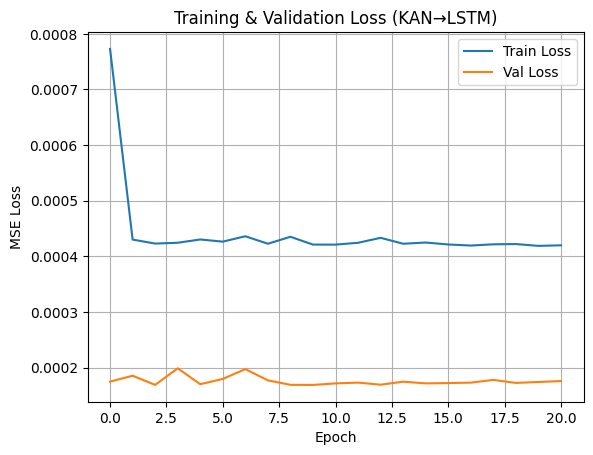

In [7]:
aapl_encoder = MLPEncoder(input_dim=input_dim,
                         layer_dims=[mlp_params['layer_0_dim']],
                         dropout=mlp_params['dropout']
                        ).to(device)

aapl_lstm = LSTMRegressor(
    input_dim=mlp_params['layer_0_dim'],
    hidden_dim=lstm_params['hidden_dim'],
    num_layers=lstm_params['num_layers'],
    dropout=lstm_params['dropout']
).to(device)

optimizer = optim.Adam([
    {'params': aapl_encoder.parameters(), 'lr': mlp_params['lr']},
    {'params': aapl_lstm.parameters(), 'lr': lstm_params['lr']}
])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
criterion = nn.MSELoss()
early_stopper = EarlyStopping(patience=20, min_delta=1e-5)

train_losses = []
val_losses = []

for epoch in range(50):
    # ---- TRAIN ----
    aapl_encoder.train()
    aapl_lstm.train()
    train_loss = 0.0
    for xb, yb, _ in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        encoded = aapl_encoder(xb)
        preds = aapl_lstm(encoded).squeeze()
        mse_loss = criterion(preds, yb)

        mse_loss.backward()
        optimizer.step()
        train_loss += mse_loss.item()

    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    # ---- VALIDATE ----
    aapl_encoder.eval()
    aapl_lstm.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb, _ in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            encoded = aapl_encoder(xb)
            preds = aapl_lstm(encoded).squeeze()
            val_loss += criterion(preds, yb).item()
    val_loss /= len(val_dl)
    val_losses.append(val_loss)

    scheduler.step(val_loss)
    early_stopper(val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.6f} | Val Loss = {val_loss:.6f}")

    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# ---- Plot ----
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Training & Validation Loss (KAN→LSTM)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()

Mean predicted return: 0.002434056
Std of predicted return: 0.0006514302
Mean actual return: 0.002365659
Std of actual return: 0.014482381
Test RMSE: 3.0927
Test MAE : 2.2075


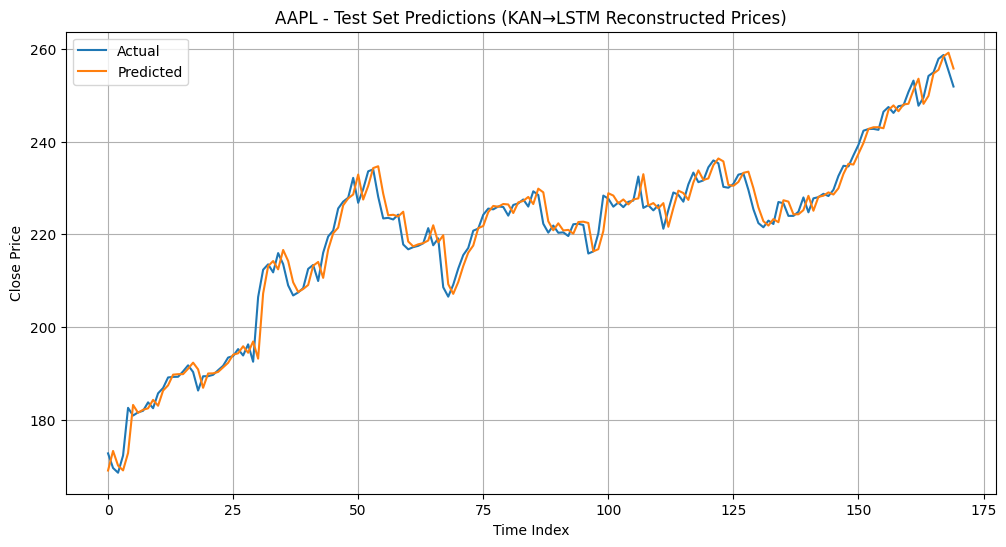

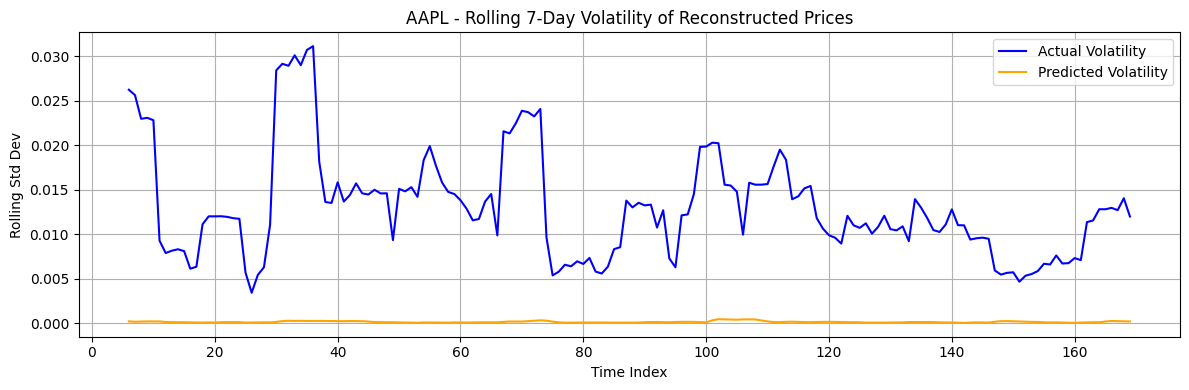

In [16]:
aapl_encoder.eval()
aapl_lstm.eval()

preds, targets, prev_prices = [], [], []

with torch.no_grad():
    for xb, yb, p_tm1 in test_dl:
        xb = xb.to(device)
        encoded = aapl_encoder(xb)
        y_pred = aapl_lstm(encoded).squeeze().cpu().numpy()

        preds.extend(y_pred)
        targets.extend(yb.numpy())
        prev_prices.extend(p_tm1.numpy())

# Convert to arrays
preds = np.array(preds)
targets = np.array(targets)
prev_prices = np.array(prev_prices)

# Reconstruct prices
pred_prices = prev_prices * np.exp(preds)
true_prices = prev_prices * np.exp(targets)

print("Mean predicted return:", np.mean(preds))
print("Std of predicted return:", np.std(preds))

print("Mean actual return:", np.mean(targets))
print("Std of actual return:", np.std(targets))

# Metrics
rmse = np.sqrt(mean_squared_error(true_prices, pred_prices))
mae = mean_absolute_error(true_prices, pred_prices)
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(true_prices, label="Actual")
plt.plot(pred_prices, label="Predicted")
plt.title(f"{stock.value} - Test Set Predictions (KAN→LSTM Reconstructed Prices)")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

import pandas as pd
# --- Rolling Volatility (Price Level) ---
def rolling_std(x, window=7):
    return pd.Series(x).rolling(window=window).std().to_numpy()

window = 7  # can tweak
rolling_true_vol = rolling_std(targets, window)
rolling_pred_vol = rolling_std(preds, window)

# --- Plot Volatility ---
plt.figure(figsize=(12, 4))
plt.plot(rolling_true_vol, label="Actual Volatility", color="blue")
plt.plot(rolling_pred_vol, label="Predicted Volatility", color="orange")
plt.title(f"{stock.value} - Rolling {window}-Day Volatility of Reconstructed Prices")
plt.xlabel("Time Index")
plt.ylabel("Rolling Std Dev")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Coke ##

In [17]:
stock = StockIndex.KO
lstm_params = BEST_LSTM_PARAMS[stock]
mlp_params = BEST_MLP_PARAMS[stock]
train_dl, val_dl, test_dl = get_log_return_loaders(
    stock,
    window_size=7,
    batch_size=lstm_params["batch_size"]
)
input_dim = next(iter(train_dl))[0].shape[-1]

Epoch 1: Train Loss = 0.001330 | Val Loss = 0.000095
Epoch 2: Train Loss = 0.000236 | Val Loss = 0.000080
Epoch 3: Train Loss = 0.000187 | Val Loss = 0.000076
Epoch 4: Train Loss = 0.000184 | Val Loss = 0.000070
Epoch 5: Train Loss = 0.000181 | Val Loss = 0.000070
Epoch 6: Train Loss = 0.000178 | Val Loss = 0.000071
Epoch 7: Train Loss = 0.000179 | Val Loss = 0.000078
Epoch 8: Train Loss = 0.000186 | Val Loss = 0.000080
Epoch 9: Train Loss = 0.000188 | Val Loss = 0.000079
Epoch 10: Train Loss = 0.000185 | Val Loss = 0.000087
Epoch 11: Train Loss = 0.000180 | Val Loss = 0.000072
Epoch 12: Train Loss = 0.000178 | Val Loss = 0.000072
Epoch 13: Train Loss = 0.000177 | Val Loss = 0.000072
Epoch 14: Train Loss = 0.000178 | Val Loss = 0.000076
Epoch 15: Train Loss = 0.000178 | Val Loss = 0.000070
Epoch 16: Train Loss = 0.000176 | Val Loss = 0.000072
Epoch 17: Train Loss = 0.000177 | Val Loss = 0.000070
Epoch 18: Train Loss = 0.000177 | Val Loss = 0.000071
Epoch 19: Train Loss = 0.000179 | Val

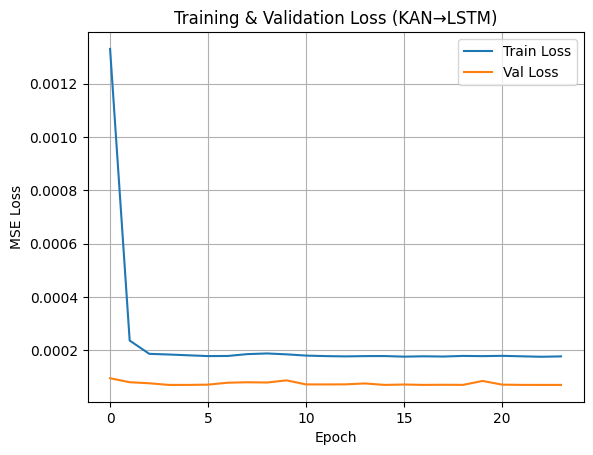

In [10]:
ko_encoder = MLPEncoder(input_dim=input_dim,
                         layer_dims=[mlp_params['layer_0_dim'], mlp_params['layer_1_dim']],
                         dropout=mlp_params['dropout']
                        ).to(device)

ko_lstm = LSTMRegressor(
    input_dim=mlp_params['layer_1_dim'],
    hidden_dim=lstm_params['hidden_dim'],
    num_layers=lstm_params['num_layers'],
    dropout=lstm_params['dropout']
).to(device)

optimizer = optim.Adam([
    {'params': ko_encoder.parameters(), 'lr': mlp_params['lr']},
    {'params': ko_lstm.parameters(), 'lr': lstm_params['lr']}
])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
criterion = nn.MSELoss()
early_stopper = EarlyStopping(patience=20, min_delta=1e-5)

train_losses = []
val_losses = []

for epoch in range(50):
    # ---- TRAIN ----
    ko_encoder.train()
    ko_lstm.train()
    train_loss = 0.0
    for xb, yb, _ in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        encoded = ko_encoder(xb)
        preds = ko_lstm(encoded).squeeze()
        mse_loss = criterion(preds, yb)

        mse_loss.backward()
        optimizer.step()
        train_loss += mse_loss.item()

    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    # ---- VALIDATE ----
    ko_encoder.eval()
    ko_lstm.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb, _ in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            encoded = ko_encoder(xb)
            preds = ko_lstm(encoded).squeeze()
            val_loss += criterion(preds, yb).item()
    val_loss /= len(val_dl)
    val_losses.append(val_loss)

    scheduler.step(val_loss)
    early_stopper(val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.6f} | Val Loss = {val_loss:.6f}")

    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# ---- Plot ----
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Training & Validation Loss (KAN→LSTM)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()

Mean predicted return: -0.00022109791
Std of predicted return: 2.645953e-05
Mean actual return: 0.00015766906
Std of actual return: 0.00826914
Test RMSE: 0.5395
Test MAE : 0.4141


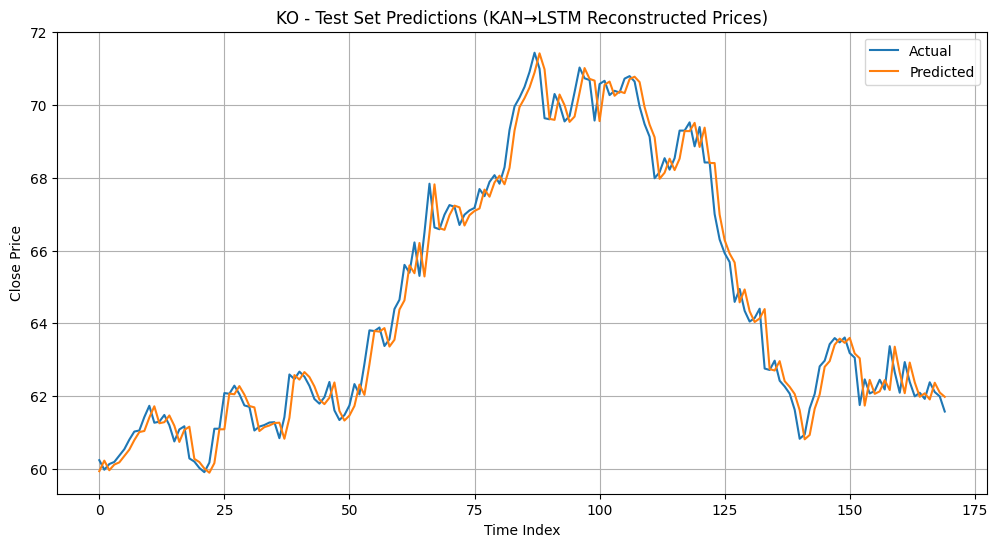

In [18]:
ko_encoder.eval()
ko_lstm.eval()

preds, targets, prev_prices = [], [], []

with torch.no_grad():
    for xb, yb, p_tm1 in test_dl:
        xb = xb.to(device)
        encoded = ko_encoder(xb)
        y_pred = ko_lstm(encoded).squeeze().cpu().numpy()

        preds.extend(y_pred)
        targets.extend(yb.numpy())
        prev_prices.extend(p_tm1.numpy())

# Convert to arrays
preds = np.array(preds)
targets = np.array(targets)
prev_prices = np.array(prev_prices)

# Reconstruct prices
pred_prices = prev_prices * np.exp(preds)
true_prices = prev_prices * np.exp(targets)

print("Mean predicted return:", np.mean(preds))
print("Std of predicted return:", np.std(preds))

print("Mean actual return:", np.mean(targets))
print("Std of actual return:", np.std(targets))

# Metrics
rmse = np.sqrt(mean_squared_error(true_prices, pred_prices))
mae = mean_absolute_error(true_prices, pred_prices)
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(true_prices, label="Actual")
plt.plot(pred_prices, label="Predicted")
plt.title(f"{stock.value} - Test Set Predictions (KAN→LSTM Reconstructed Prices)")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()